The goal of this notebook is to explore the distributions of the test, valid and train data sets. We want to make sure that we are providing a fair test. The utility of the model is based on extrapolation which is tough to do.

In [1]:
import pandas as pd
import numpy as np
import deepchem as dc
import importlib

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\gzyla\Documents\projects\HPLC\HPLC_ML_Leaderboard\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lig

In [2]:
df = pd.read_csv('..\..\ml\shareddata\All_column_charity.csv')
df

,Unnamed: 0,index,SMILES,RT,Speed,i-PrOH_proportion,Literature,Column
0,0,0,O=C(OC)N(C)[C@@H](B1OC(C)(C)C(C)(C)O1)CC2=CC=C...,2.14,0.5,0.050000,10.1039/C9SC04534A,OJ3
1,1,0,O=C(OC)N(C)[C@H](B1OC(C)(C)C(C)(C)O1)CC2=CC=CC=C2,1.81,0.5,0.050000,10.1039/C9SC04534A,OJ3
2,2,1,C=CCCCCCCC[C@@H](C[C@@]1(CCCC1=O)c2ccccc2)C=O,0.97,2.0,0.076923,10.1002/anie.202001100,AD3
3,3,2,C[C@H](C[S](=O)(=O)c1ccc(C)cc1)c2ccc(cc2)C(F)(F)F,2.13,0.5,0.300000,10.1039/C8QO01291A,IA
4,4,2,C[C@@H](C[S](=O)(=O)c1ccc(C)cc1)c2ccc(cc2)C(F)...,2.30,0.5,0.300000,10.1039/C8QO01291A,IA
...,...,...,...,...,...,...,...,...
25862,25862,14144,COc1ccc2N(COCc3ccccc3)C(=O)[C@](CO)(\C=C\c4ccc...,119.10,0.8,0.050000,10.31635/ccschem.019.20190064,IC3
25863,25863,14144,COc1ccc2N(COCc3ccccc3)C(=O)[C@@](CO)(\C=C\c4cc...,98.90,0.8,0.050000,10.31635/ccschem.019.20190064,IC3
25864,25864,14145,Fc1cccc2[C@@H](OC(=O)C(c3ccccc3)c4ccccc4)OC(=O...,75.30,0.8,0.100000,10.1002/anie.202012445,IC3
25865,25865,14145,Fc1cccc2[C@H](OC(=O)C(c3ccccc3)c4ccccc4)OC(=O)c12,99.60,0.8,0.100000,10.1002/anie.202012445,IC3


Unnamed: 0 column seems to be the index. The index column seems to be enantiomer pairs. There is an odd number of rows which could mean that there are incomplete pairs, meso compounds or mistakes? From the paper "The dataset constitutes the retention time of 25,847 molecules, which contains 11,720 pairs of enantiomers, experimental information, and HPLC column information". 
25,847 - (11,720*2) = 2407. In the paper it mentions that some SMILES can't be parsed properly which might account for the 20 SMILES difference.

In [32]:
# lets confirm
index_counts = df['index'].value_counts()
odd_counts_indices = index_counts[index_counts % 2 != 0]
print("Indices with odd counts:")
print(odd_counts_indices)

Indices with odd counts:
index
13627    1
12767    1
12507    1
847      1
13463    1
        ..
10050    1
10051    1
10060    1
10061    1
14146    1
Name: count, Length: 2427, dtype: int64


There are 2427 molecules without an enantiomer pair which matches what we expected.

In [4]:
from utils import to_canonical_smiles
df['canonical_smiles'] = df['SMILES'].apply(to_canonical_smiles)
df

,Unnamed: 0,index,SMILES,RT,Speed,i-PrOH_proportion,Literature,Column,canonical_smiles
0,0,0,O=C(OC)N(C)[C@@H](B1OC(C)(C)C(C)(C)O1)CC2=CC=C...,2.14,0.5,0.050000,10.1039/C9SC04534A,OJ3,COC(=O)N(C)[C@H](Cc1ccccc1)B1OC(C)(C)C(C)(C)O1
1,1,0,O=C(OC)N(C)[C@H](B1OC(C)(C)C(C)(C)O1)CC2=CC=CC=C2,1.81,0.5,0.050000,10.1039/C9SC04534A,OJ3,COC(=O)N(C)[C@@H](Cc1ccccc1)B1OC(C)(C)C(C)(C)O1
2,2,1,C=CCCCCCCC[C@@H](C[C@@]1(CCCC1=O)c2ccccc2)C=O,0.97,2.0,0.076923,10.1002/anie.202001100,AD3,C=CCCCCCCC[C@H](C=O)C[C@]1(c2ccccc2)CCCC1=O
3,3,2,C[C@H](C[S](=O)(=O)c1ccc(C)cc1)c2ccc(cc2)C(F)(F)F,2.13,0.5,0.300000,10.1039/C8QO01291A,IA,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1
4,4,2,C[C@@H](C[S](=O)(=O)c1ccc(C)cc1)c2ccc(cc2)C(F)...,2.30,0.5,0.300000,10.1039/C8QO01291A,IA,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1
...,...,...,...,...,...,...,...,...,...
25862,25862,14144,COc1ccc2N(COCc3ccccc3)C(=O)[C@](CO)(\C=C\c4ccc...,119.10,0.8,0.050000,10.31635/ccschem.019.20190064,IC3,COc1ccc2c(c1)[C@](/C=C/c1ccccc1)(CO)C(=O)N2COC...
25863,25863,14144,COc1ccc2N(COCc3ccccc3)C(=O)[C@@](CO)(\C=C\c4cc...,98.90,0.8,0.050000,10.31635/ccschem.019.20190064,IC3,COc1ccc2c(c1)[C@@](/C=C/c1ccccc1)(CO)C(=O)N2CO...
25864,25864,14145,Fc1cccc2[C@@H](OC(=O)C(c3ccccc3)c4ccccc4)OC(=O...,75.30,0.8,0.100000,10.1002/anie.202012445,IC3,O=C1O[C@H](OC(=O)C(c2ccccc2)c2ccccc2)c2cccc(F)c21
25865,25865,14145,Fc1cccc2[C@H](OC(=O)C(c3ccccc3)c4ccccc4)OC(=O)c12,99.60,0.8,0.100000,10.1002/anie.202012445,IC3,O=C1O[C@@H](OC(=O)C(c2ccccc2)c2ccccc2)c2cccc(F...


In [6]:
from utils import get_chiral_info

# Store all SMILES in a set for quick lookup
all_smiles_in_df = set(df['canonical_smiles'].tolist())

results = []
for idx, row in df.iterrows(): # Or iterate only through problematic_rows
    smiles = row['canonical_smiles']
    mol_obj, is_chiral, enantiomer_smiles = get_chiral_info(smiles)

    if mol_obj is None:
        results.append({'SMILES': smiles, 'Status': 'Invalid SMILES'})
        continue

    if not is_chiral:
        results.append({'SMILES': smiles, 'Status': 'Not Chiral', 'Enantiomer_Index': row['index']})
    elif enantiomer_smiles is None: # This happens if it was identified as meso by the function
        results.append({'SMILES': smiles, 'Status': 'Meso Compound', 'Enantiomer_Index': row['index']})
    else:
        if enantiomer_smiles in all_smiles_in_df:
            results.append({'SMILES': smiles, 'Status': 'Chiral - Enantiomer Found', 'Enantiomer_SMILES': enantiomer_smiles, 'Enantiomer_Index': row['index']})
        else:
            results.append({'SMILES': smiles, 'Status': 'Chiral - Enantiomer NOT Found', 'Enantiomer_SMILES': enantiomer_smiles, 'Enantiomer_Index': row['index']})

results_df = pd.DataFrame(results)
print(results_df['Status'].value_counts())

Status
Chiral - Enantiomer Found        22457
Chiral - Enantiomer NOT Found     3400
Not Chiral                          10
Name: count, dtype: int64


In [8]:
results_df[results_df['Status'] == 'Chiral - Enantiomer NOT Found']

,SMILES,Status,Enantiomer_SMILES,Enantiomer_Index
2,C=CCCCCCCC[C@H](C=O)C[C@]1(c2ccccc2)CCCC1=O,Chiral - Enantiomer NOT Found,C=CCCCCCCC[C@@H](C=O)C[C@@]1(c2ccccc2)CCCC1=O,1
97,CC[C@H](c1ccccc1)[C@@H](N)C(=O)N(C)C,Chiral - Enantiomer NOT Found,CC[C@@H](c1ccccc1)[C@H](N)C(=O)N(C)C,49
112,C[C@H](c1ccccc1)[C@@H](N)C(=O)N(C)C,Chiral - Enantiomer NOT Found,C[C@@H](c1ccccc1)[C@H](N)C(=O)N(C)C,57
153,Cc1ccccc1[C@@H](C)[C@@H](N)C(=O)N(C)C,Chiral - Enantiomer NOT Found,Cc1ccccc1[C@H](C)[C@H](N)C(=O)N(C)C,78
184,CC(C)c1cccc(/C=C/C(=O)O[C@@H]2C[C@@H](C)CC[C@H...,Chiral - Enantiomer NOT Found,CC(C)c1cccc(/C=C/C(=O)O[C@H]2C[C@H](C)CC[C@@H]...,94
...,...,...,...,...
25852,COc1ccc(C[C@@H]2C(=O)OC(c3ccccc3)=C[C@@H]2c2cc...,Chiral - Enantiomer NOT Found,COc1ccc(C[C@H]2C(=O)OC(c3ccccc3)=C[C@H]2c2cccc...,14138
25853,COc1ccc(C[C@H]2C(=O)OC(c3ccccc3)=C[C@@H]2c2ccc...,Chiral - Enantiomer NOT Found,COc1ccc(C[C@@H]2C(=O)OC(c3ccccc3)=C[C@H]2c2ccc...,14138
25858,Brc1ccc([C@@H]2C=C(c3ccccc3)C[C@H]2c2ccccc2)cc1,Chiral - Enantiomer NOT Found,Brc1ccc([C@H]2C=C(c3ccccc3)C[C@@H]2c2ccccc2)cc1,14141
25861,CC(C)N[C@H](c1ccccc1)[C@H](C)O,Chiral - Enantiomer NOT Found,CC(C)N[C@@H](c1ccccc1)[C@@H](C)O,14143


There are 3400 rows but we should expect 2427 which leaves 973 unaccounted for. We would need to remove the 2427 based on their indexes and examine the 973 more closely and what their assigned pairs are. 

In [ ]:
# remove the 2427 which contains not enantiomers which should leave us with 973 compositions that are labeled enantiomers 
# but our code is unable to assign them
indexes_to_remove = odd_counts_indices.index.to_list()
index_to_examine= results_df['Enantiomer_Index'][results_df['Status'] == 'Chiral - Enantiomer NOT Found'].to_list()
print(len(index_to_examine))
other_list_set = set(indexes_to_remove)
filtered_list = [item for item in index_to_examine if item not in other_list_set]
len(filtered_list)


3400


1127

The length is greater than expected by 154

In [47]:
import utils
importlib.reload(utils)
from utils import are_diastereomers
for i in filtered_list:
    pairs = results_df['Enantiomer_SMILES'][results_df['Enantiomer_Index']==i].to_list()
    bool_value = are_diastereomers(pairs[0],pairs[1])
    if bool_value == False:
        print(i)

It turns out that they are not enantiomers but diasteriomers. We should discuss if they need to be removed

In [ ]:
# non-tetrahedral chirality? Axial, planar, helicity, topological
results_df['SMILES'][results_df['Status'] == 'Not Chiral'].to_list()

['CCCCCC(=C=C(CC(C)(C)C(=O)OCC)c1ccccc1)C#Cc1ccc(C#N)cc1',
 'CCCCCC(=C=C(CC(C)(C)C(=O)OCC)c1ccccc1)C#Cc1ccc(C#N)cc1',
 'CCCCCC(=C=C(CC(C)(C)C(=O)OCC)c1ccccc1)C#Cc1ccc(C#N)cc1',
 'CCCCCC(=C=C(CC(C)(C)C(=O)OCC)c1ccccc1)C#Cc1ccc(C#N)cc1',
 'CCCCC(=C=Cc1ccccc1)c1ccccc1C',
 'CCCCC(=C=Cc1ccccc1)c1ccccc1C',
 'CCCCC(=C=Cc1ccccc1)c1ccccc1',
 'CCCCC(=C=Cc1ccccc1)c1ccccc1',
 'CCCCCC(=C=C(CC(F)(F)F)c1ccccc1)C#CCn1c2ccccc2c2ccccc21',
 'CCCCCC(=C=C(CC(F)(F)F)c1ccccc1)C#CCn1c2ccccc2c2ccccc21']

In [48]:
smiles_counts = df['canonical_smiles'].value_counts()
duplicated_smiles = smiles_counts[smiles_counts > 1]
print("\nSMILES strings appearing more than once:")
print(duplicated_smiles)

# Inspect rows for these duplicated SMILES
duplicated_rows = df[df['canonical_smiles'].isin(duplicated_smiles.index)].sort_values(by='canonical_smiles')
print("\nRows with duplicated SMILES:")
print(duplicated_rows)


SMILES strings appearing more than once:
canonical_smiles
O=C(OCc1ccccc1)C1=C[C@]2([N+](=O)[O-])Oc3ccccc3[C@@H]2C1    17
c1ccc([C@H]2CCc3ccccc3N2)cc1                                10
c1ccc([C@@H]2CCc3ccccc3N2)cc1                               10
CCCCC[C@@H]1CCc2ccccc2N1                                     8
CCC[C@H]1CCc2ccccc2N1                                        8
                                                            ..
COC(=O)C[C@H](O)c1ccccc1Cl                                   2
CCOC(=O)[C@H](CC(=O)c1ccc(C#N)cc1)n1ncccc1=O                 2
C[C@](C=O)(C/C=C/C=C/c1ccccc1F)c1ccccc1                      2
COc1ccccc1[C@@](c1ccccc1)(c1ccc(O)cc1)c1ccc(C)[nH]1          2
COc1cccc(C2=C[C@@H]3CCC=C[C@@H]3N2S(=O)(=O)C(C)(C)C)c1       2
Name: count, Length: 1670, dtype: int64

Rows with duplicated SMILES:
       Unnamed: 0  index                                         SMILES  \
15040       15040   8049                Brc1ccc(cc1)[C@@H]2CCc3ccccc3N2   
24318       24318  13289    

In [49]:
smiles = df['SMILES'].values
labels = df["RT"].values
features = df.filter(['index','Speed','i-PrOH_proportion','Column'])
dataset = dc.data.NumpyDataset(X=features, y=labels, ids=smiles)
print("\n--- Created DeepChem Dataset ---")
print(f"Dataset IDs (SMILES): {dataset.ids[:5]}...") # Show first few SMILES
print(f"Dataset Features (X shape): {dataset.X.shape}")
print(f"Dataset Labels (y shape): {dataset.y.shape}")


--- Created DeepChem Dataset ---
Dataset IDs (SMILES): ['O=C(OC)N(C)[C@@H](B1OC(C)(C)C(C)(C)O1)CC2=CC=CC=C2'
 'O=C(OC)N(C)[C@H](B1OC(C)(C)C(C)(C)O1)CC2=CC=CC=C2'
 'C=CCCCCCCC[C@@H](C[C@@]1(CCCC1=O)c2ccccc2)C=O'
 'C[C@H](C[S](=O)(=O)c1ccc(C)cc1)c2ccc(cc2)C(F)(F)F'
 'C[C@@H](C[S](=O)(=O)c1ccc(C)cc1)c2ccc(cc2)C(F)(F)F']...
Dataset Features (X shape): (25867, 4)
Dataset Labels (y shape): (25867,)


In [50]:
# Bemis, Guy W., and Mark A. Murcko split
splitter = dc.splits.ScaffoldSplitter()

In [51]:
indices= splitter.split(dataset)
len(indices)

3

In [52]:
train_index = indices[0]
test_index = indices[1]
valid_index = indices[2]

print(f'train, test and valid sizes {len(train_index)},{len(test_index)},{len(valid_index)}')

train, test and valid sizes 20693,2587,2587


In [53]:
# count enantiomer pairs in sets
train_df= df.iloc[train_index]
test_df= df.iloc[test_index]
valid_df= df.iloc[valid_index]

train_enantiomer_pair_count = len(train_df['index'])-len(train_df['index'].drop_duplicates())
test_enantiomer_pair_count = len(test_df['index'])-len(test_df['index'].drop_duplicates())
valid_enantiomer_pair_count = len(valid_df['index'])-len(valid_df['index'].drop_duplicates())

print(f'the number of enantiomer pairs in the train, test and valid set are {train_enantiomer_pair_count},{test_enantiomer_pair_count} and {valid_enantiomer_pair_count} respectively')

the number of enantiomer pairs in the train, test and valid set are 9469,1215 and 1036 respectively


Based on the numbers it looks like data sets contain both enantiomer pairs for the most part

In [54]:
from utils import grand_tanimoto_similarity_mean
test_valid_similarity= grand_tanimoto_similarity_mean(test_df['SMILES'],valid_df['SMILES'])
test_train_similarity= grand_tanimoto_similarity_mean(test_df['SMILES'],train_df['SMILES'])
valid_train_similarity= grand_tanimoto_similarity_mean(valid_df['SMILES'],train_df['SMILES'])
print(test_valid_similarity,test_train_similarity,valid_train_similarity)

0.1343324003393441 0.1305664465953525 0.12974208278039692


The valid and test set are not similar

In [55]:
from utils import tanimoto_similarity_mean
similarity_list = tanimoto_similarity_mean(test_df['SMILES'],valid_df['SMILES'])


In [56]:
import matplotlib.pyplot as plt

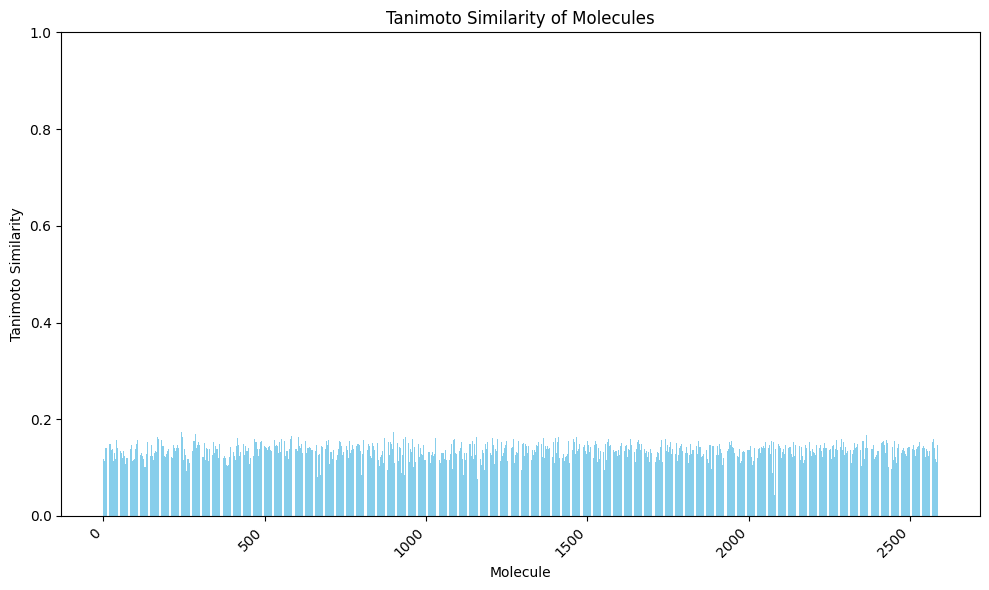

In [57]:
# Creating the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(range(0,len(similarity_list)), similarity_list, color='skyblue')

# Adding labels and title
plt.xlabel('Molecule')
plt.ylabel('Tanimoto Similarity')
plt.title('Tanimoto Similarity of Molecules')
plt.ylim(0, 1) # Tanimoto similarity is between 0 and 1

# Rotating x-axis labels if necessary for readability
plt.xticks(rotation=45, ha='right')

# Displaying the plot
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

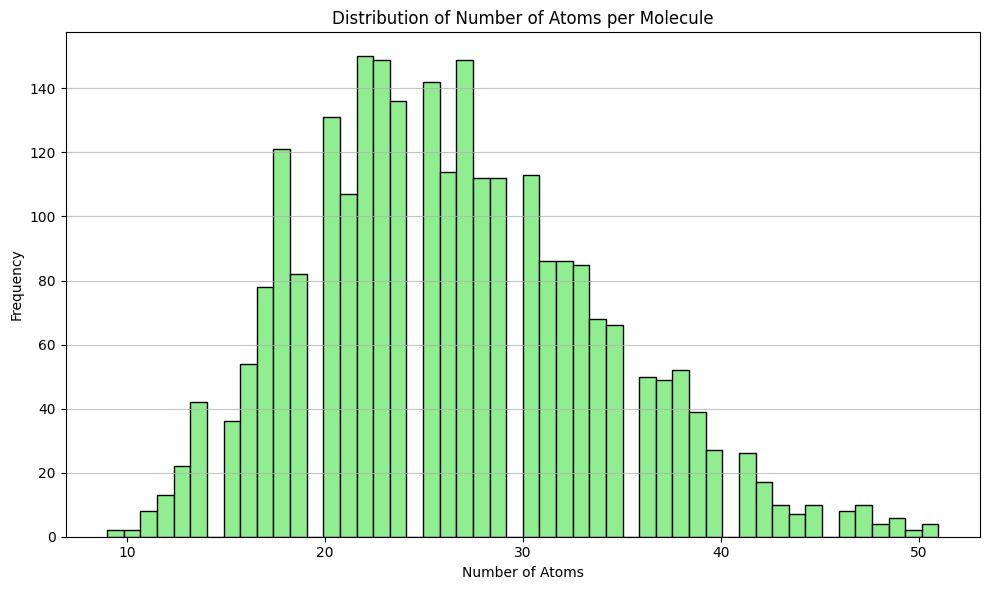

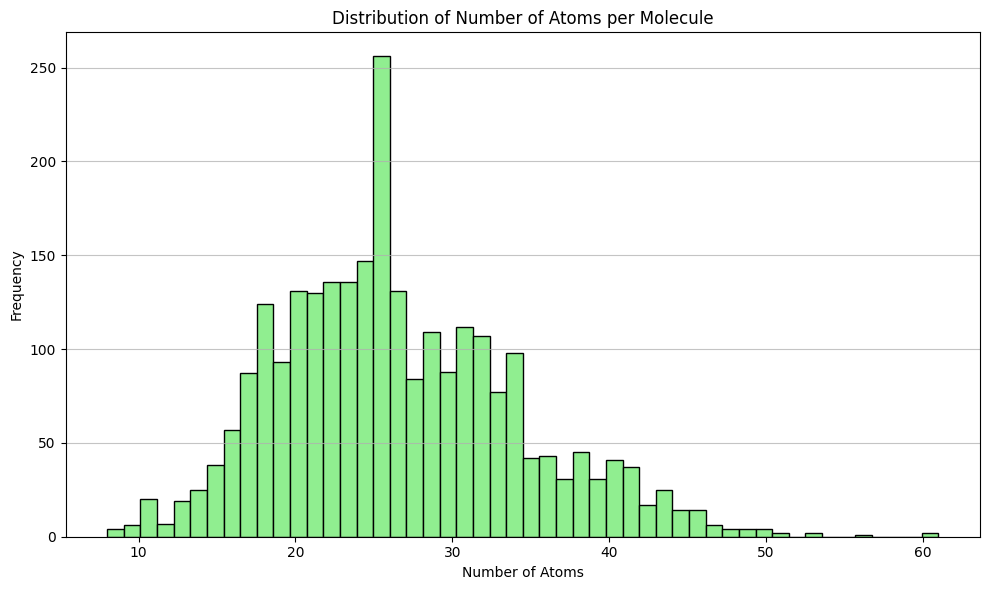

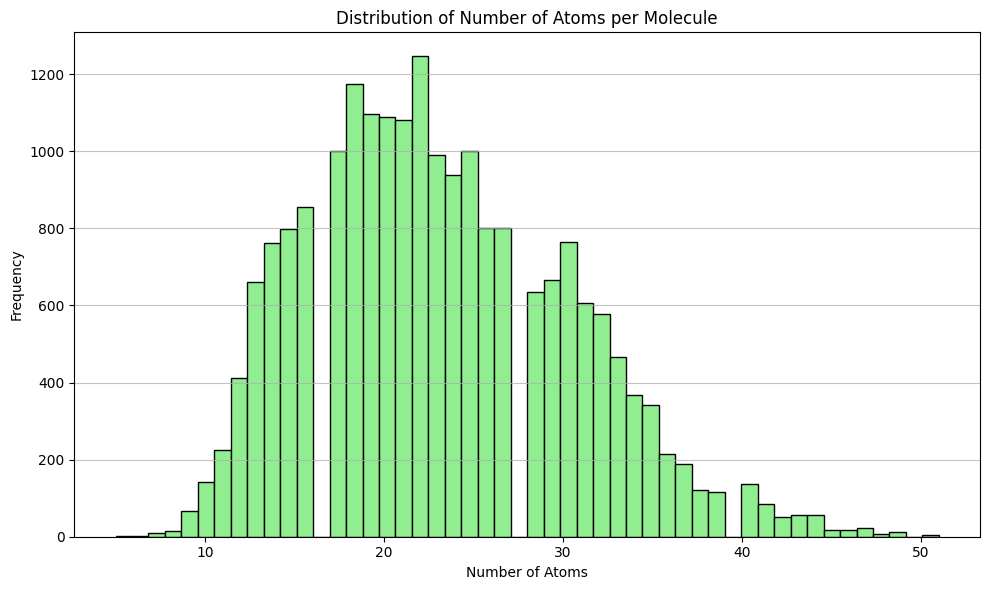

In [58]:
# number of atoms vs molecule count (H,C,N,O,total)
from utils import plot_num_atoms_per_molecule

plot_num_atoms_per_molecule(test_df['SMILES'].to_list())
plot_num_atoms_per_molecule(valid_df['SMILES'].to_list())
plot_num_atoms_per_molecule(train_df['SMILES'].to_list())



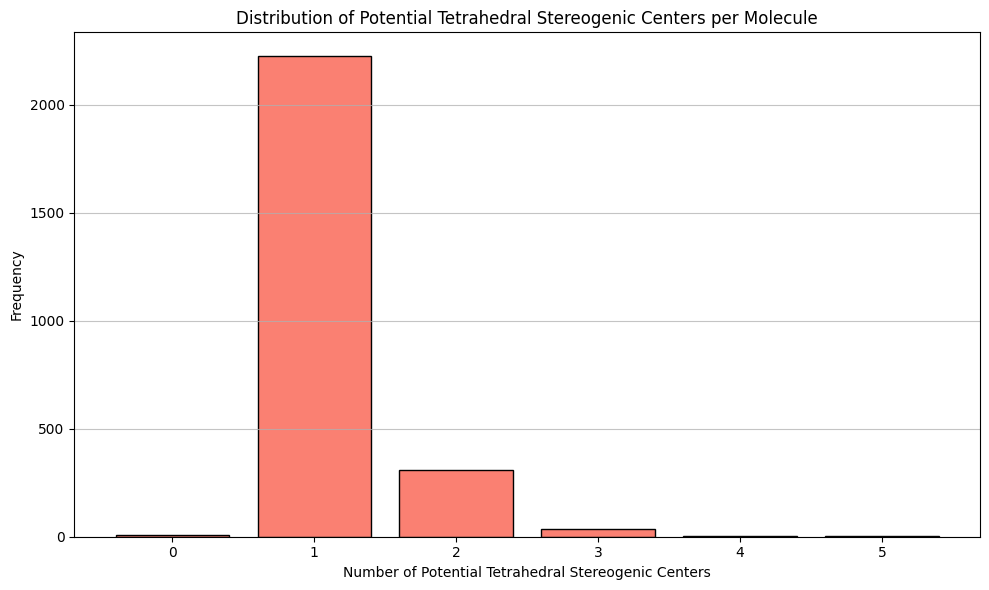

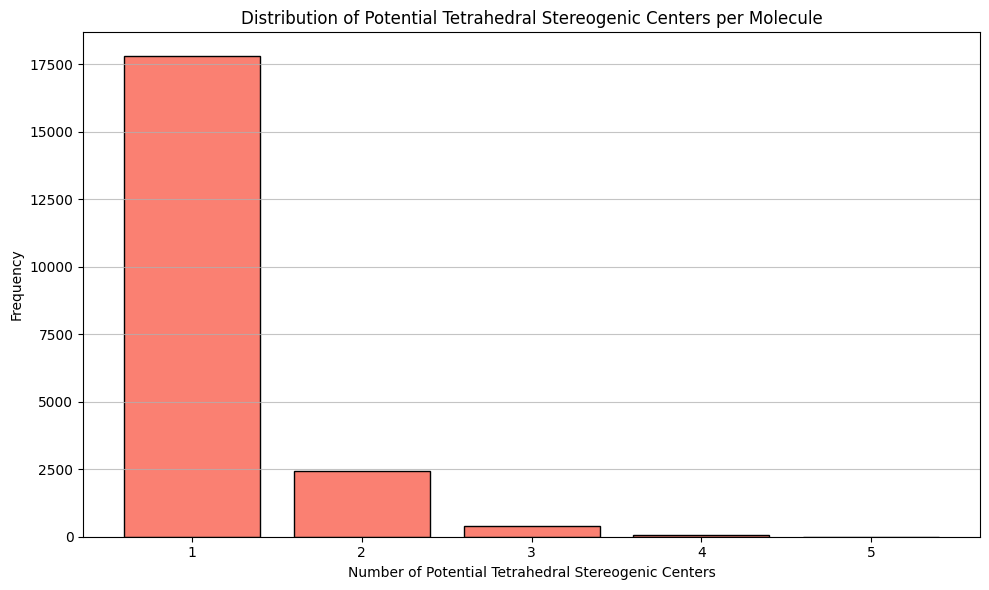

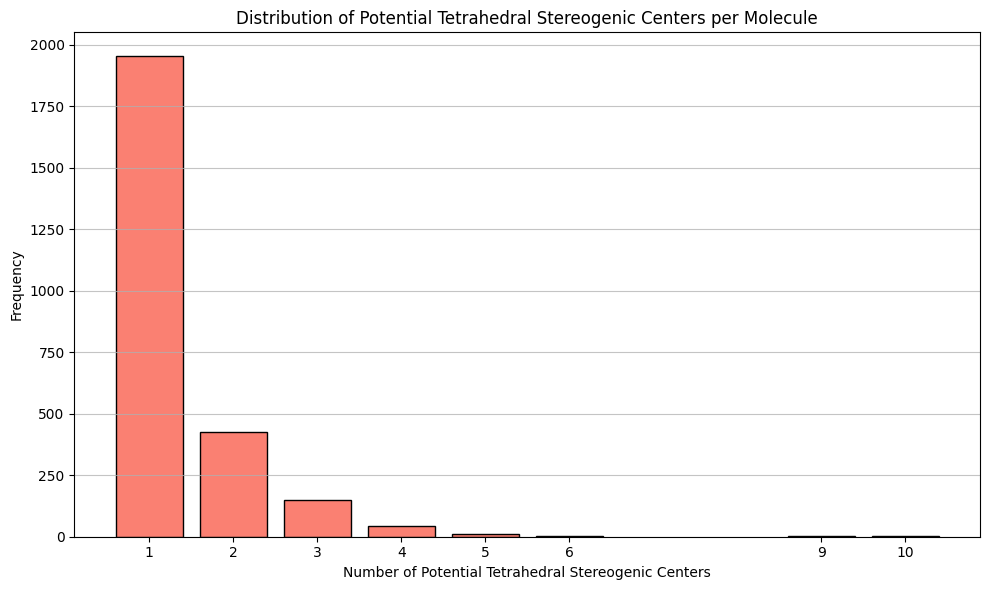

In [59]:
# Sterogenic centers
from utils import plot_stereogenic_centers_per_molecule
plot_stereogenic_centers_per_molecule(test_df['SMILES'].to_list())
plot_stereogenic_centers_per_molecule(train_df['SMILES'].to_list())
plot_stereogenic_centers_per_molecule(valid_df['SMILES'].to_list())

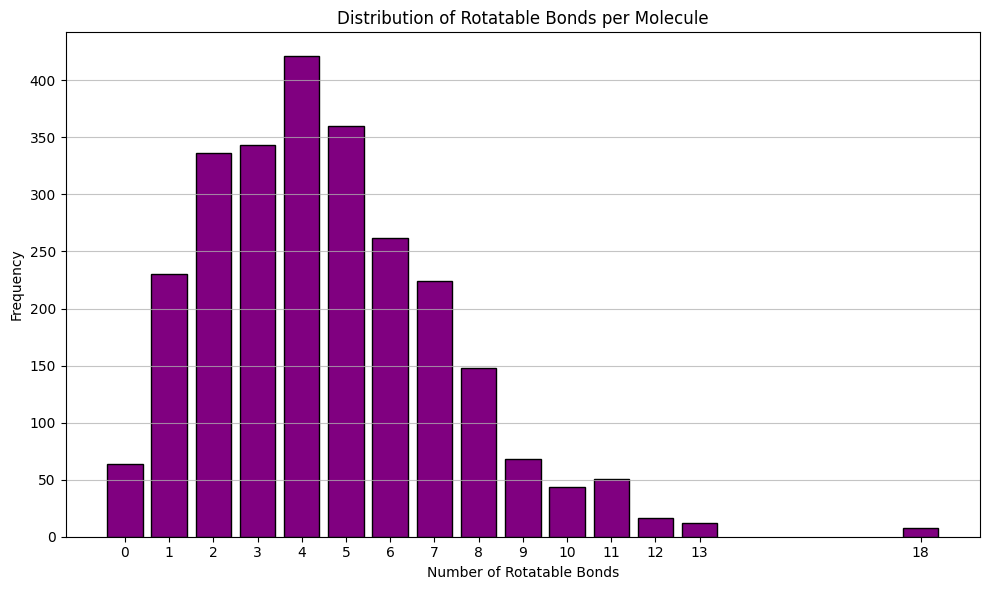

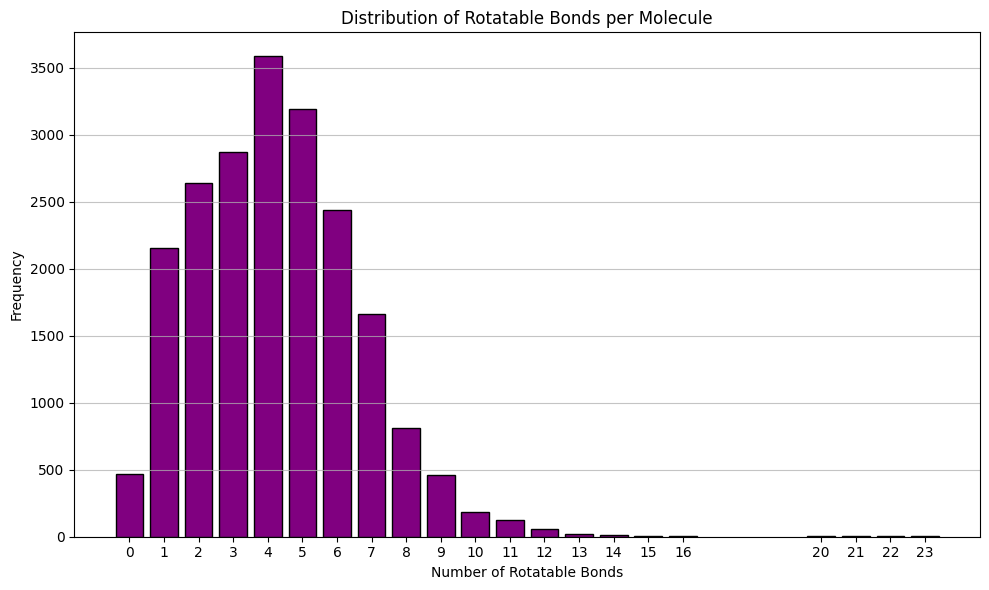

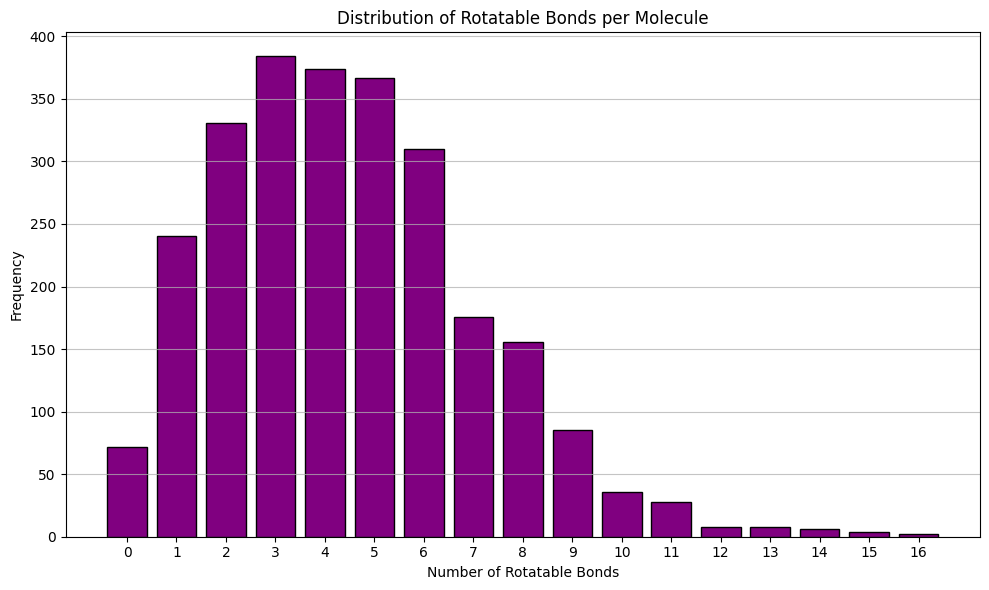

In [60]:
# rotatble bond number
from utils import plot_rotatable_bonds_per_molecule

plot_rotatable_bonds_per_molecule(test_df['SMILES'].to_list())
plot_rotatable_bonds_per_molecule(train_df['SMILES'].to_list())
plot_rotatable_bonds_per_molecule(valid_df['SMILES'].to_list())

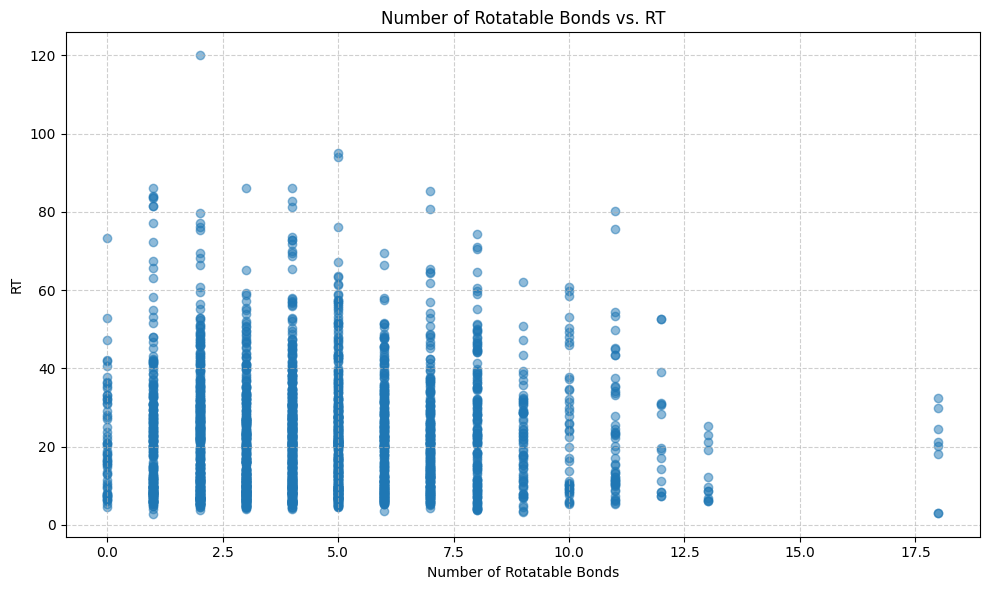


Processed 2587 valid molecules.


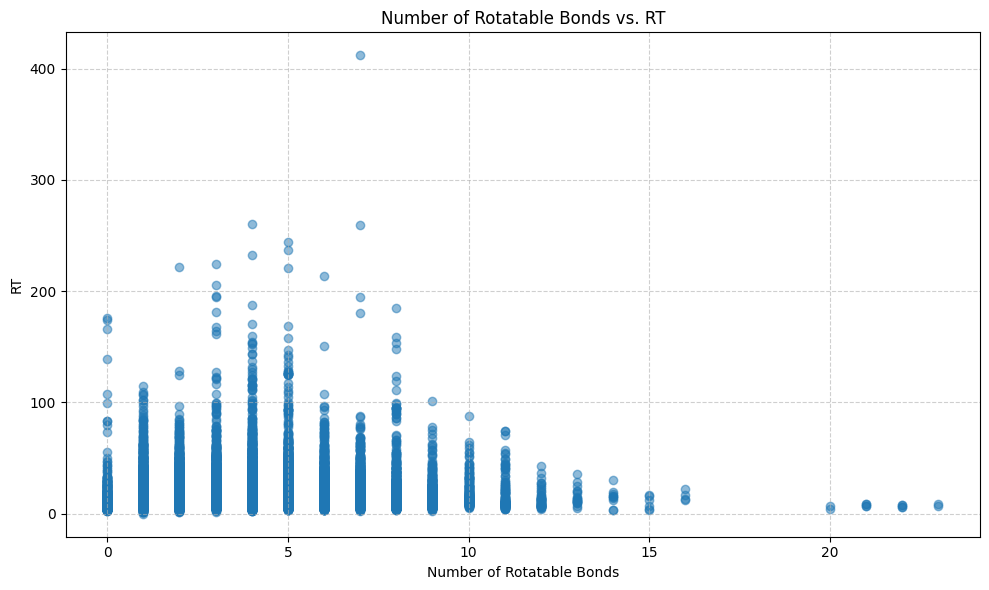


Processed 20693 valid molecules.


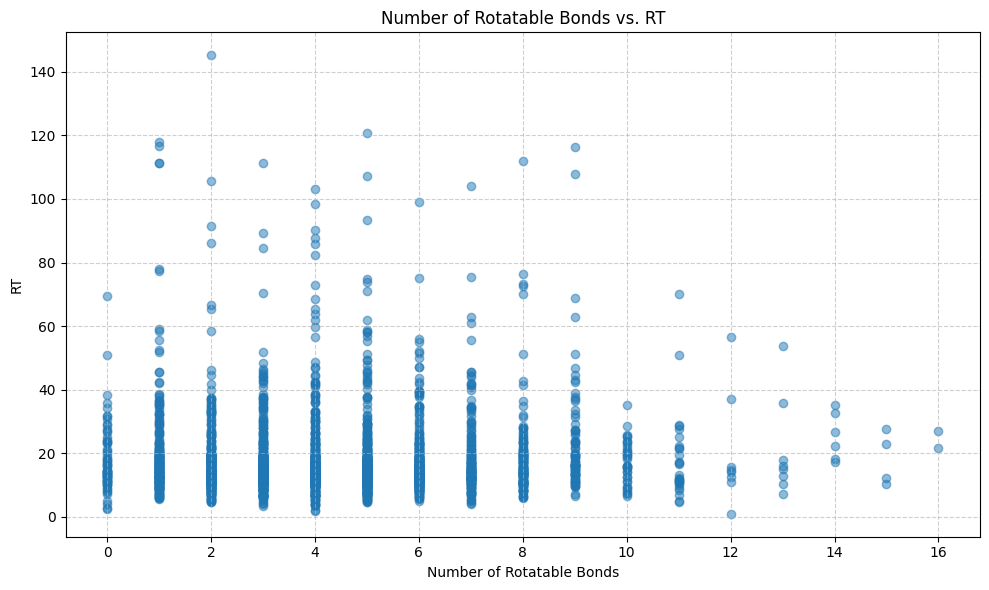


Processed 2587 valid molecules.


In [61]:
from utils import plot_rotatable_bonds_vs_property

plot_rotatable_bonds_vs_property(test_df, 'SMILES', 'RT')
plot_rotatable_bonds_vs_property(train_df, 'SMILES', 'RT')
plot_rotatable_bonds_vs_property(valid_df, 'SMILES', 'RT')